# Synthetic Image Generator for YOLOv8

This notebook generates synthetic images for the training, validation and testing. The output of this notebook is required by the **Training+Export.ipynb** notebook.

Authors(s): *Diptabrata Paul, Martin Fränzl*

<Figure size 640x480 with 0 Axes>

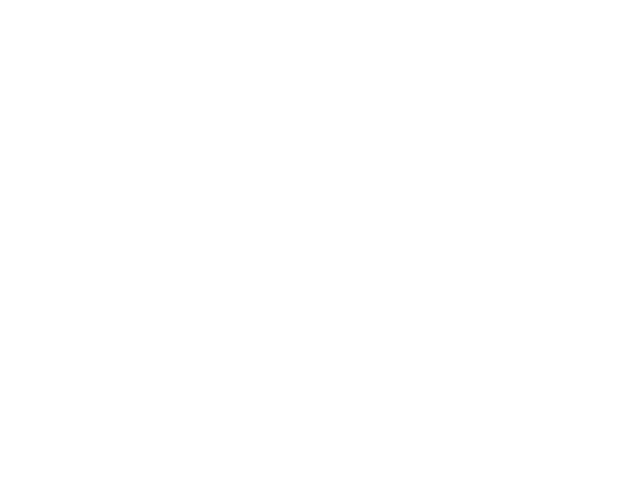

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import matplotlib.patches as patches
from matplotlib import colormaps as cmaps
import os
from tqdm import tqdm
import yaml
from importlib import reload  # Python 3.4+

import image_generator as ig 
pi = np.pi
from multiprocessing import Pool
from PIL import Image
%matplotlib widget
plt.figure()

## Display single image for parameter adjustments

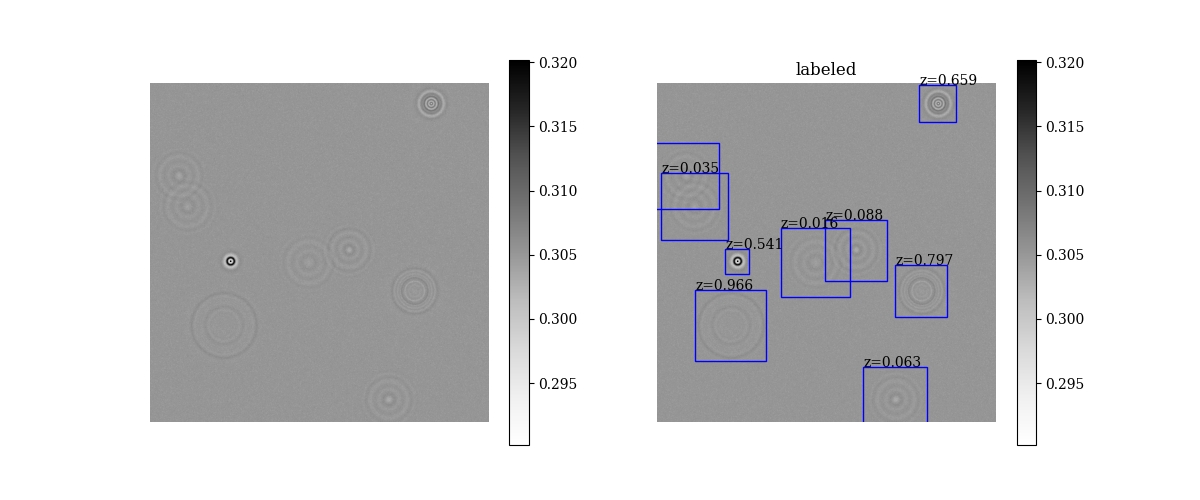

In [ ]:
n_list = [1,10]                            # Number of points in each class

label_list = ['Ripple']               # Class of points
color_list = ['yellow']             # Color List for each class

# parameters for each class: [[[intensity], [radius], [width]]]
spot_params = [[[0], [4]]]
ripple_params = [[[1,1], [100,100], [0,1567]]]

parameter_list = [ripple_params]

image_size = 512            # Dimension 
distance = 10               # Min distance between points
offset = 10                 # Boundary padding
reload(ig)
objects = ig.getRandom_parallel(n_list, image_size, distance, offset, label_list, parameter_list,np.random.default_rng(), n_gaussian=False)
plt.close("all")
noise_range = [1e-7,20e-7]
snr_range = [0.7,3]
# i_range = [1,1]
plt.close("all")
fig = plt.figure(figsize=(12,5))

# plt.figure()
bboxes, labels, params, image = ig.generateImage_parallel(objects, image_size, noise_range)

# image = image.clip(-50,50)
# print(params)
# plt.clf()
ax = plt.subplot(1,2,1)
ax.axis("off")
bg = 2e4/2**16
plt.imshow(image, cmap=cmaps["Grays"],vmin =bg-0.015,vmax=bg+0.015)
# plt.imshow(noise, cmap=cmaps["Grays"])
plt.colorbar()
# plt.colorbar()
ax = plt.subplot(1,2,2)
plt.title("labeled")
plt.imshow(image, cmap=cmaps["Grays"],vmin =bg-0.015,vmax=bg+0.015)
plt.colorbar()
# ax = fig.gca()
# print(bboxes, labels,params)
#plt.colorbar()
# print(bboxes.shape)
for bbox, label,pars in zip(bboxes, labels,params):
    x, y = bbox[0:2]
    x1, y1 = bbox[2:]
    ax.add_patch(patches.Rectangle((x,y), x1-x, y1-y, linewidth=1, edgecolor="blue", facecolor='none'))
    ax.annotate(f"z={pars/1567:.3f}", (x,y))
    # ax.legend()
    # ax.clear()
ax.axis("off")
plt.show()


In [4]:
np.mean((image-2e4/2**16)**2)

np.float64(1.0314195722984574e-06)

In [5]:
np.mean(noise**2)

NameError: name 'noise' is not defined

## Generate images for training, validation and testing

In [9]:
subdir = 'Dataset/'
nimages = [50000, 5000, 1000]
folders = ['train', 'val', 'test']
test_noiselevels = noise_range*3
# levels = 10
# nimages = [1000]*levels
# folders = [f'test{i}' for i in range(levels)]
# test_noiselevels = list(np.linspace(*noise_range, levels))# use noise range for train and val, and ascending noise levels for test
import time

if not os.path.exists(subdir):
    os.mkdir(subdir)

l_dir = subdir  + 'labels'
i_dir = subdir + 'images'
if not os.path.exists(i_dir):
    os.mkdir(i_dir)
if not os.path.exists(l_dir):
    os.mkdir(l_dir)
for i, prefix in enumerate(folders):
    image_dir = i_dir + '/' + prefix + '/'
    if not os.path.exists(image_dir):
        os.mkdir(image_dir)
    label_dir = l_dir + '/' + prefix + '/'
    if not os.path.exists(label_dir):
        os.mkdir(label_dir)
for i, prefix in enumerate(folders):


    # print(f"generating {prefix} data... ",end=" ", flush=True)
    vectorized_index = np.vectorize(lambda labels,item: labels.index(item))
    rngs = []
    def init():
        global rng
        rng = np.random.default_rng()
        time.sleep(rng.uniform(0,2))
    def call(j):
        labelname = l_dir + '/' + prefix + '/' + 'image_{:05d}.txt'.format(j,2)    
        fname = i_dir + '/' + prefix + '/' + 'image_{:05d}.tif'.format(j,2)

        objects = ig.getRandom_parallel(n_list, image_size, distance, offset, label_list, parameter_list,rng=rng)
        if(len(objects) == 0):
            f = open(labelname, "w")
            f.write("\n")
            f.close()
            return
        bboxes, labels, z ,image = ig.generateImage_parallel(objects, image_size, test_noiselevels[i],rng) 

        
        x, y = np.array([[obj.x,obj.y] for obj in objects]).T
        x+=0.5 #account for downsampling artifact
        y-=0.25
        # plt.imsave(fname, image, cmap='gray',vmin=0,vmax=1)
        image = (image*(2**16-1)).astype(np.uint16) #rescale image to fit into 16 bit tiff
        Image.fromarray(image).save(fname, quality=100)
        x /= image_size
        y /= image_size
        bbox_x = ((bboxes[:,0] + bboxes[:,2]) / 2) / image_size
        bbox_y = ((bboxes[:,1] + bboxes[:,3]) / 2) / image_size
        bbox_w = (bboxes[:,2] - bboxes[:,0]) / image_size
        bbox_h = (bboxes[:,3] - bboxes[:,1]) / image_size
        z = z/1567
        class_id = vectorized_index(label_list, labels)
        # print(class_id)

        
        np.savetxt(labelname, np.column_stack([class_id,bbox_x,bbox_y,bbox_w,bbox_h,z, x, y]), fmt='%g')
    with Pool(initializer=init) as pool:
        for _ in tqdm(pool.imap_unordered(call,range(nimages[i])),total=nimages[i], desc=prefix):
            pass
        # print(annotations)
    
        
# ig.exportConfig(subdir + 'info.txt', nimages, label_list, parameters_list, n_list, snr_range, i_range, distance, offset)

test: 100%|██████████| 1000/1000 [00:01<00:00, 860.16it/s]


### Generate .yaml file:

In [5]:
file_path = 'dataset_hard.yaml'

dict = {}

dict["train"]=os.getcwd() + '/' + subdir + "images/" + "train"
dict["val"]=os.getcwd() + '/' + subdir + "images/" + "val"
dict["kpt_shape"] = [1,2]
dict["num_extra_parameters"] = 1
dict['nc'] = len(label_list)
dict['names'] = label_list

with open(file_path, 'w') as file:
    yaml.dump(dict, file, default_flow_style=True)

In [8]:
levels_dir = subdir+"/levels"
if not os.path.exists(levels_dir):
    os.mkdir(levels_dir)

In [9]:
for folder in folders:
    if "test" not in folder: #skip non-"test" folders
        continue
    try:
        i=int(folder[-1])
    except ValueError:
        i= ""
    file_path = levels_dir + f'/dataset{i}.yaml'

    dict = {}
    i_dir =  os.getcwd() + '/' + subdir + "images/" + folder
    dict["train"]=os.getcwd() + '/' + subdir + "images/" + "train"
    dict["val"]=i_dir
    dict["kpt_shape"] = [1,2]
    dict["num_extra_parameters"] = 1
    dict['nc'] = len(label_list)
    dict['names'] = label_list

    with open(file_path, 'w') as file:
        yaml.dump(dict, file, default_flow_style=True)

In [12]:
plt.clf()
plt.imshow(z_stack)

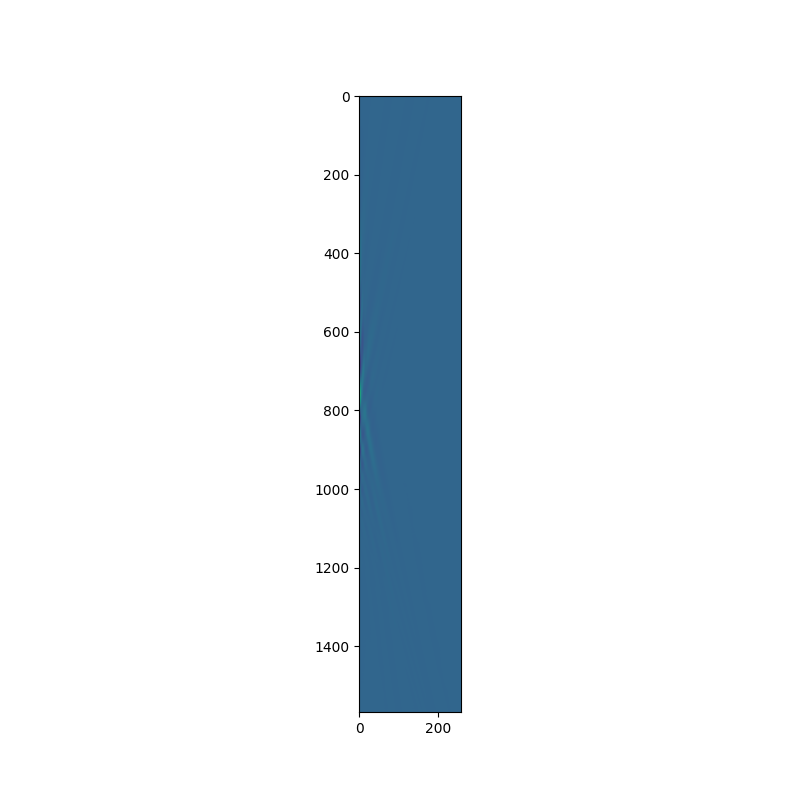

In [13]:
plt.show()

In [79]:
test_noiselevels

array([5.e-07, 5.e-07, 5.e-07, ..., 3.e-06, 3.e-06, 3.e-06])

In [94]:
import PIL
from matplotlib.patches import Rectangle
def plot_gt(path,ax):
    data=np.loadtxt(path.replace("images", "labels").replace("jpg","txt").replace("tif","txt")).T
    # print(data)
    print(data.shape)
    cls = data[0]
    bboxes = data[1:5].T
    z = data[5]
    x_p,y_p = data[6:]
    # print(bboxes)
    img = PIL.Image.open(path)
    img = ax.imshow(np.array(img),cmap="grey", vmin=1.9e4, vmax=2.1e4)
    ax.axis("off")
    for bbox,z_value in zip(bboxes,z):
        x,y,w,h = bbox*512
        rect = Rectangle((x-0.5*w,y-0.5*h),h,w, linewidth=1, edgecolor="blue", facecolor='none')
        ax.text(*rect.get_xy(),f"z={z_value:.3f}")
        ax.add_patch(rect)
    return bboxes,z, img

(8, 5)


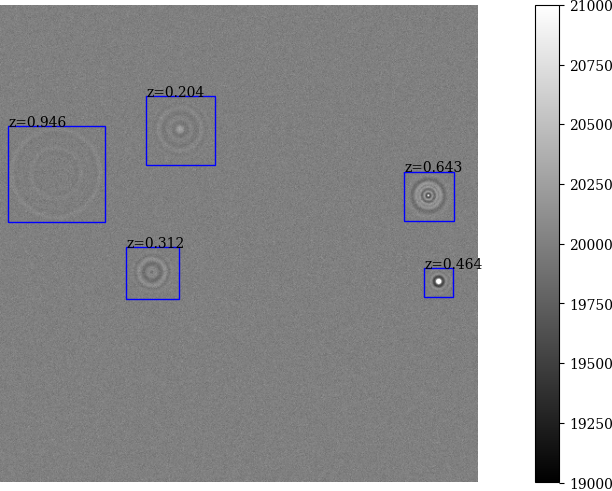

In [99]:
plt.clf()
_,_,img = plot_gt("Dataset/images/test0/image_00006.tif",plt.gca())
plt.colorbar(img)
plt.show()

In [115]:
np.r_[:8]

array([0, 1, 2, 3, 4, 5, 6, 7])

In [ ]:
''